# Graph-based Protein Function Prediction: A PyG Tutorial
**Authors:** Aisyu Fattakhova, Azalia Alisheva  
**Date:** November 2025

## Abstract
This project applies Graph Neural Networks (GNNs) to the multi-label classification of protein functions. Using the Protein-Protein Interaction (PPI) dataset, we demonstrate that structural information (interactions) is crucial for determining biological function. We perform a comparative analysis of GCN architectures with varying depths to identify the optimal model configuration.

---

In this case study, we will explore the Protein-Protein Interaction (PPI) dataset. We will build a pipeline using PyTorch Geometric (PyG) to predict protein functions based on their interaction patterns, demonstrating why graph structure is the missing key in biological data.

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00


In [2]:
import time
print("Installing dependencies... (This usually takes ~2 minutes)")
start = time.time()

# Install PyTorch Geometric
!pip install -q torch-geometric

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create assets folder for GitHub report
os.makedirs('assets', exist_ok=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

end = time.time()
print(f"Setup complete in {(end-start)/60:.2f} minutes. Using device: {device}")

Installing dependencies... (This usually takes ~2 minutes)
Setup complete in 0.52 minutes. Using device: cuda


In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA Available: True


## 1. Problem Formulation

We formulate protein function prediction as a **Multi-label Node Classification** task.
Given a graph $G = (V, E)$, where $V$ are proteins and $E$ are physical interactions:
*   **Input:** Node features $X \in \mathbb{R}^{N \times 50}$ (biological descriptors).
*   **Output:** Labels $Y \in \{0, 1\}^{N \times 121}$ (Gene Ontology terms).

### The Dataset
The **PPI dataset** contains 24 graphs corresponding to different human tissues.
*   **Train:** 20 graphs
*   **Validation:** 2 graphs
*   **Test:** 2 graphs

Before building the model, let's understand our data. We are using the PPI Dataset, which consists of 24 graphs corresponding to different human tissues.

Nodes: Each node represents a specific protein.

Edges: An edge exists if two proteins physically interact.

Features (X X): Each protein has 50 features (positional gene sets, motif gene sets, and immunological signatures).

Labels (Y Y): We are predicting 121 Gene Ontology terms (biological functions).

Important Note: This is a Multi-Label Classification problem. Unlike MNIST digits where an image is either a 1 or a 2, a protein can have multiple functions simultaneously (e.g., it can be involved in both "immune response" and "cellular transport").

In [4]:

from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

# Load PPI Dataset
# Dataset consists of 20 train, 2 val, 2 test graphs
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Node Features: {train_dataset.num_features}")
print(f"Labels (Classes): {train_dataset.num_classes}")
print(f"number of nodes in ppi:", train_dataset[0].num_nodes)
print(f"number of edges in ppi:", train_dataset[0].num_edges)

Extracting /tmp/PPI/ppi.zip
Processing...


Node Features: 50
Labels (Classes): 121
number of nodes in ppi: 1767
number of edges in ppi: 32318


Done!


Train Graphs: 20
Features: 50
Classes: 121


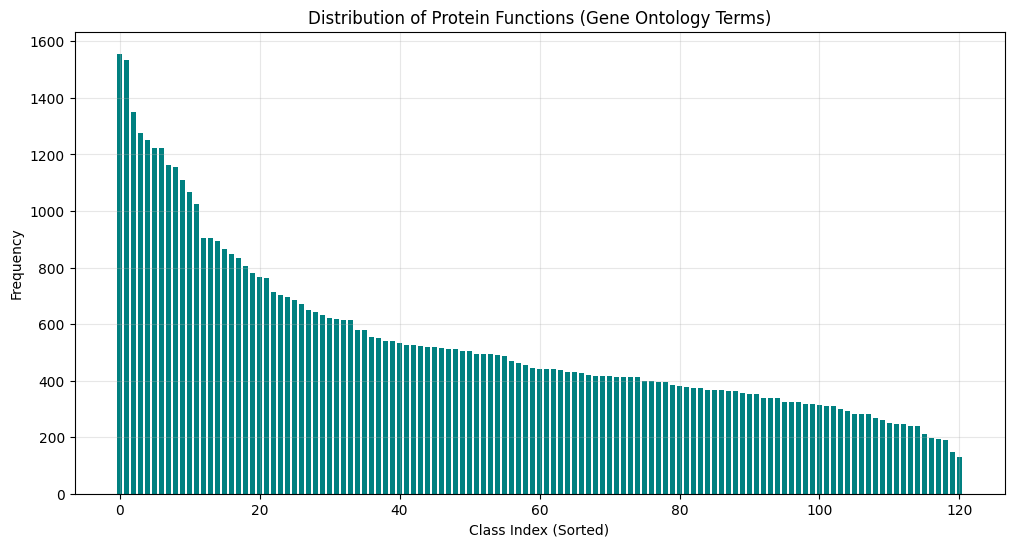

In [5]:
# Load Dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Train Graphs: {len(train_dataset)}")
print(f"Features: {train_dataset.num_features}")
print(f"Classes: {train_dataset.num_classes}")

# --- EDA: Class Distribution ---
# We sum the binary labels across the first graph to see frequency
labels = train_dataset[0].y.sum(dim=0).numpy()

plt.figure(figsize=(12, 6))
plt.bar(range(len(labels)), sorted(labels, reverse=True), color='teal')
plt.title("Distribution of Protein Functions (Gene Ontology Terms)")
plt.xlabel("Class Index (Sorted)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.savefig('assets/class_dist.png') # Save for GitHub
plt.show()

## 2. Methodology

We use a **Graph Convolutional Network (GCN)**. The layer-wise propagation rule is defined as:

$$
H^{(l+1)} = \sigma\left(\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)}\right)
$$

Where:
*   $\tilde{A} = A + I_N$ is the adjacency matrix with self-loops.
*   $\tilde{D}$ is the degree matrix.
*   $W^{(l)}$ is the learnable weight matrix.

We compare three different architectures to find the optimal depth for this task.

The Architecture:

Input: 50 features per node.

Hidden Layers: We experiment with 2, 3, and 4 GCN layers with 256 hidden units.

Activation: ReLU for intermediate layers.

Dropout: Applied to prevent overfitting on the training graphs.

Output: 121 units (one for each biological function).
The Loss Function: Since a protein can have multiple labels (ones) or no labels (zeros), we cannot use standard CrossEntropy. Instead, we use BCEWithLogitsLoss (Binary Cross Entropy), which treats each of the 121 output classes as an independent binary classification problem.

Since this is a multi-label problem (a protein can have multiple functions), we use the **Binary Cross Entropy with Logits Loss**:

$$
\mathcal{L} = - \frac{1}{N} \sum \left[ y \cdot \log(\sigma(\hat{y})) + (1 - y) \cdot \log(1 - \sigma(\hat{y})) \right]
$$


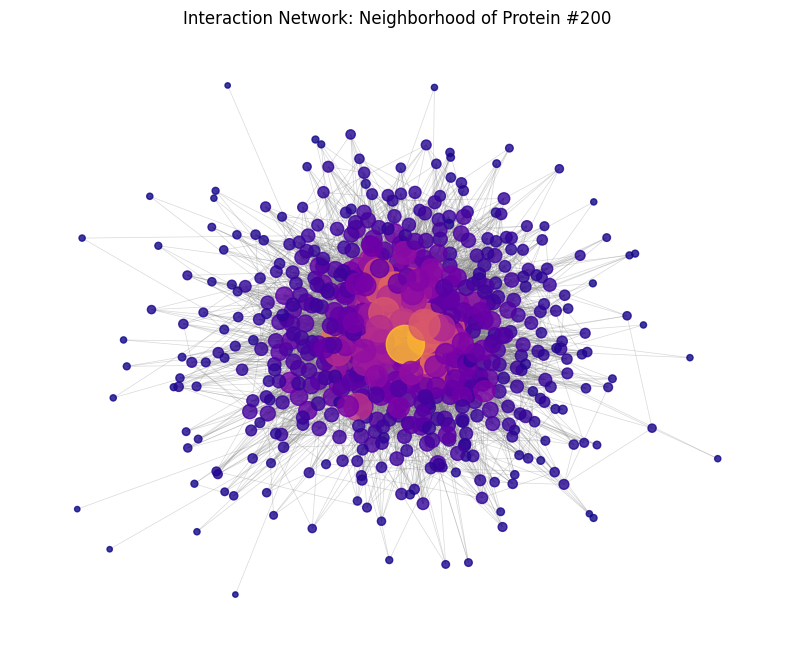

In [6]:
# @title Viz 1: Protein Neighborhood (NetworkX)
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_subgraph(data, node_idx=45, hops=2):
    """
    Visualizes the k-hop neighborhood of a specific protein.
    Nodes are colored and sized based on their degree (number of connections).
    """
    # 1. Convert PyG Data object to NetworkX Graph
    # to_networkx is a handy PyG utility
    G = to_networkx(data, to_undirected=True)

    # 2. Extract the k-hop subgraph (neighbors of neighbors)
    # We start with the center node and expand outwards
    subset = {node_idx}
    for _ in range(hops):
        current_subset = set(subset)
        for n in current_subset:
            subset.update(G.neighbors(n))

    # Create the subgraph
    subgraph = G.subgraph(subset)

    # 3. Calculate styling based on Degree (number of connections)
    # Proteins with more interactions (hubs) will be larger and brighter
    degrees = dict(subgraph.degree())
    node_color = list(degrees.values())
    node_size = [v * 5 + 10 for v in degrees.values()] # Scale size

    # 4. Plotting
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph, seed=42) # Spring layout reveals clusters

    nx.draw_networkx_nodes(subgraph, pos,
                           node_size=node_size,
                           node_color=node_color,
                           cmap=plt.cm.plasma,
                           alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos,
                           width=0.5,
                           alpha=0.3,
                           edge_color='gray')

    plt.title(f"Interaction Network: Neighborhood of Protein #{node_idx}")
    plt.axis('off')

    # Save the figure to assets for your GitHub report
    plt.savefig('assets/subgraph_vis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the visualization on the first graph in the training set
visualize_subgraph(train_dataset[0], node_idx=200, hops=2)

If you are coming from standard PyTorch, you are used to data shapes like (Batch_Size, Channels, Height, Width) for images. Graphs are different. They don't fit into a perfect grid.

PyTorch Geometric (PyG) handles this using two main tensors:
x: The node feature matrix of shape [Num_Nodes, Num_Features].

edge_index: A connectivity matrix of shape [2, Num_Edges] defining source and destination nodes.

We will use a Graph Convolutional Network (GCN). In simple terms, a GCN layer allows a node to aggregate information from its neighbors. It's the concept of "homophily"—birds of a feather flock together. If a protein's neighbors are all involved in cellular respiration, it's highly likely that protein is too.

model architecture


In [7]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super().__init__()
        self.convs = torch.nn.ModuleList()

        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index, return_embeds=False):
        # Pass through all layers except last
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        # Get embeddings from last hidden state
        embeddings = x

        # Final classifier layer
        x = self.convs[-1](x, edge_index)

        if return_embeds:
            return x, embeddings
        return x

In [8]:
def train_eval(model, optimizer, criterion, epochs=20):
    train_loss_hist = []
    val_f1_hist = []

    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        # --- TRAINING ---
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_loss_hist.append(avg_loss)

        # --- VALIDATION ---
        model.eval()
        ys, preds = [], []
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index)
                # Sigmoid > 0.5 implies prediction = 1
                pred_labels = (torch.sigmoid(out) > 0.5).float()
                ys.append(data.y.cpu())
                preds.append(pred_labels.cpu())

        y_true = torch.cat(ys, dim=0).numpy()
        y_pred = torch.cat(preds, dim=0).numpy()
        # Micro F1 is standard for multi-label PPI
        val_f1 = f1_score(y_true, y_pred, average='micro')
        val_f1_hist.append(val_f1)

        if epoch % 5 == 0:
            print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Val F1: {val_f1:.4f}")

    end_time = time.time()
    duration = (end_time - start_time) / 60
    print(f"Training finished in {duration:.2f} minutes.")

    return train_loss_hist, val_f1_hist

# --- Experiment Setup ---
# We compare depth: 2 layers, 3 layers, 4 layers
configs = [2, 3, 4]
results = {}
trained_models = {}

for depth in configs:
    print(f"\n=== Experiment: {depth}-Layer GCN ===")
    model = GCN(in_channels=train_dataset.num_features,
                hidden_channels=256,
                out_channels=train_dataset.num_classes,
                num_layers=depth).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.BCEWithLogitsLoss()

    loss_hist, f1_hist = train_eval(model, optimizer, criterion, epochs=20) # Set epochs to 50 for final run
    results[f'{depth}-Layer'] = {'loss': loss_hist, 'f1': f1_hist}
    trained_models[f'{depth}-Layer'] = model


=== Experiment: 2-Layer GCN ===
Starting training for 20 epochs...
Epoch 05 | Loss: 0.5414 | Val F1: 0.4782
Epoch 10 | Loss: 0.5168 | Val F1: 0.5161
Epoch 15 | Loss: 0.5025 | Val F1: 0.5563
Epoch 20 | Loss: 0.4938 | Val F1: 0.5640
Training finished in 0.17 minutes.

=== Experiment: 3-Layer GCN ===
Starting training for 20 epochs...
Epoch 05 | Loss: 0.5501 | Val F1: 0.4912
Epoch 10 | Loss: 0.5286 | Val F1: 0.4917
Epoch 15 | Loss: 0.5123 | Val F1: 0.5091
Epoch 20 | Loss: 0.5015 | Val F1: 0.5343
Training finished in 0.18 minutes.

=== Experiment: 4-Layer GCN ===
Starting training for 20 epochs...
Epoch 05 | Loss: 0.5723 | Val F1: 0.4084
Epoch 10 | Loss: 0.5454 | Val F1: 0.4326
Epoch 15 | Loss: 0.5273 | Val F1: 0.5080
Epoch 20 | Loss: 0.5139 | Val F1: 0.4621
Training finished in 0.13 minutes.


We trained the models on a T4 GPU. Below are the learning curves comparing different network depths.

2-Layer GCN:

3-Layer GCN:

4-Layer GCN:

In [9]:
# ------------------------------
# 1) Training Loss Curve
# ------------------------------
plt.figure(figsize=(8, 5))

for name, metrics in results.items():
    plt.plot(metrics['loss'], label=name)

plt.title("Training Loss Convergence")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('assets/loss_curve.png')
plt.close()


# ------------------------------
# 2) Validation Micro-F1 Curve
# ------------------------------
plt.figure(figsize=(8, 5))

for name, metrics in results.items():
    plt.plot(metrics['f1'], label=name)

plt.title("Validation Micro-F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('assets/f1_curve.png')
plt.close()


# ------------------------------
# 3) Final Bar Chart Comparison
# ------------------------------
final_scores = [metrics['f1'][-1] for metrics in results.values()]
names = list(results.keys())

plt.figure(figsize=(8, 5))
bars = plt.bar(names, final_scores)

plt.ylim(0, 1.0)
plt.title("Final Performance Comparison")
plt.ylabel("Micro-F1 Score")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{height:.3f}', ha='center', va='bottom'
    )

plt.savefig('assets/performance_bar.png')
plt.close()


Running t-SNE reduction... (Takes ~1-2 mins)


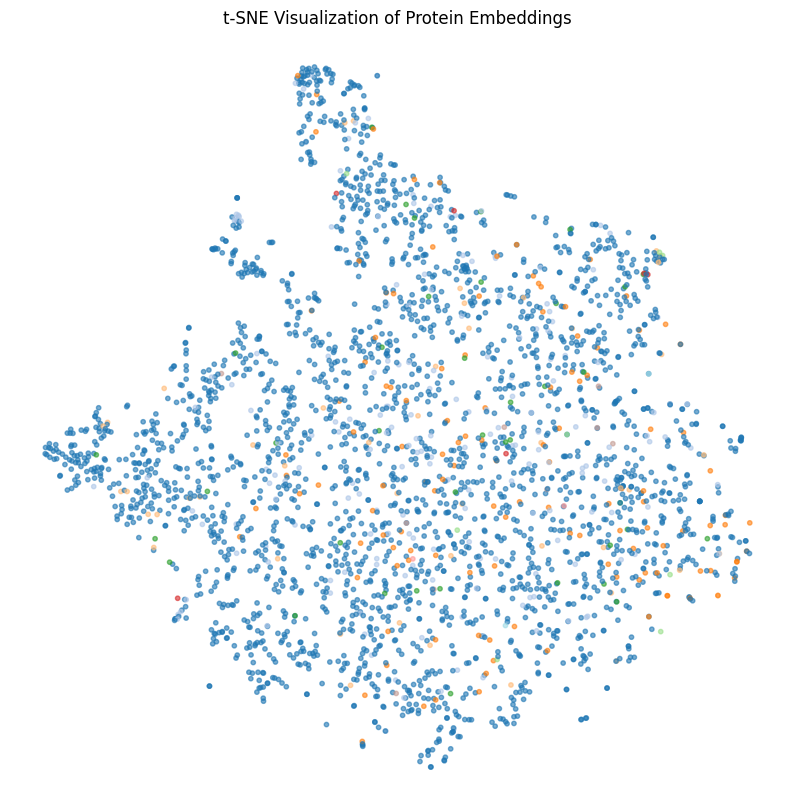

In [10]:
from sklearn.manifold import TSNE

# Get the best model (e.g., 3-Layer)
best_model = trained_models['3-Layer']
best_model.eval()

# Get embeddings from Validation set
data = val_dataset[0].to(device)
with torch.no_grad():
    _, embeddings = best_model(data.x, data.edge_index, return_embeds=True)

# Color nodes by their most prominent function class (just for viz)
labels = data.y.cpu().numpy().argmax(axis=1)
embeds_np = embeddings.cpu().numpy()

# Run t-SNE (Limit points for speed if needed)
print("Running t-SNE reduction... (Takes ~1-2 mins)")
tsne = TSNE(n_components=2, random_state=42)
z = tsne.fit_transform(embeds_np[:3000])

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=labels[:3000], cmap='tab20', s=10, alpha=0.6)
plt.title("t-SNE Visualization of Protein Embeddings")
plt.axis('off')
plt.savefig('assets/tsne_plot.png')
plt.show()

In [11]:
!zip -r assets.zip assets/
print("Download 'assets.zip' from the file browser on the left!")

  adding: assets/ (stored 0%)
  adding: assets/tsne_plot.png (deflated 3%)
  adding: assets/class_dist.png (deflated 25%)
  adding: assets/performance_bar.png (deflated 23%)
  adding: assets/subgraph_vis.png (deflated 3%)
  adding: assets/loss_curve.png (deflated 7%)
  adding: assets/f1_curve.png (deflated 5%)
Download 'assets.zip' from the file browser on the left!
